In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import cv2
import scipy.spatial
import matplotlib.path as mplPath
import networkx as nx
import itertools
import os

# Mount Google Drive (if using Colab)
from google.colab import drive
drive.mount('/content/drive')

# Set paths
path = "./drive/MyDrive/画像解析コードの共有/python応用_中心線の抽出"
fname = "PM_nuc_sample1_MAX_220520_2354-1968col_T60,z31,zo3,512,sp1,av0,la2_crop5_elong"
edge_folder = "normalized_edgeData_smoothed"

# Moving average for smoothing
def moving_avg(x, n):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[n:] - cumsum[:-n]) / float(n)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Parameters
t = 15       # Number of frames
o = 10       # Extension length based on average direction
m1, m2 = 0.05, 0.95  # Points removed from start/end for smoothing
mm = 65      # Window size for moving average
samples = [0]

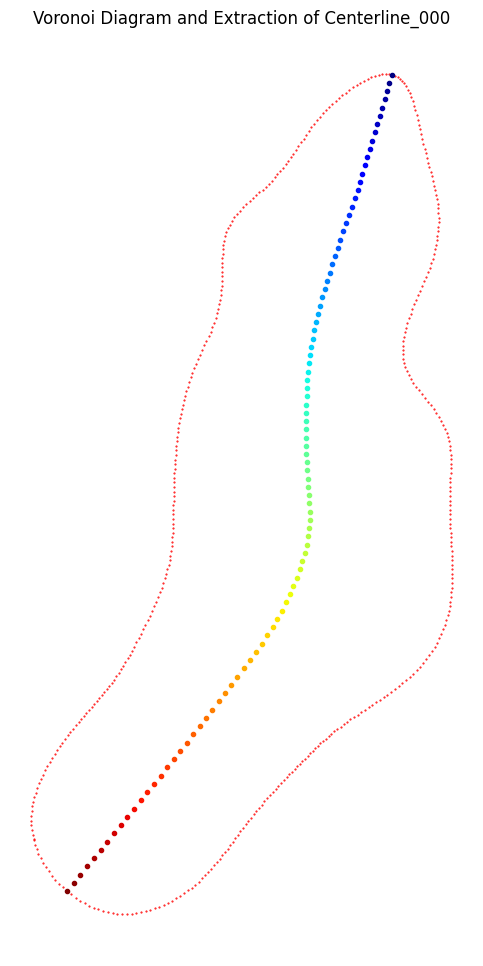

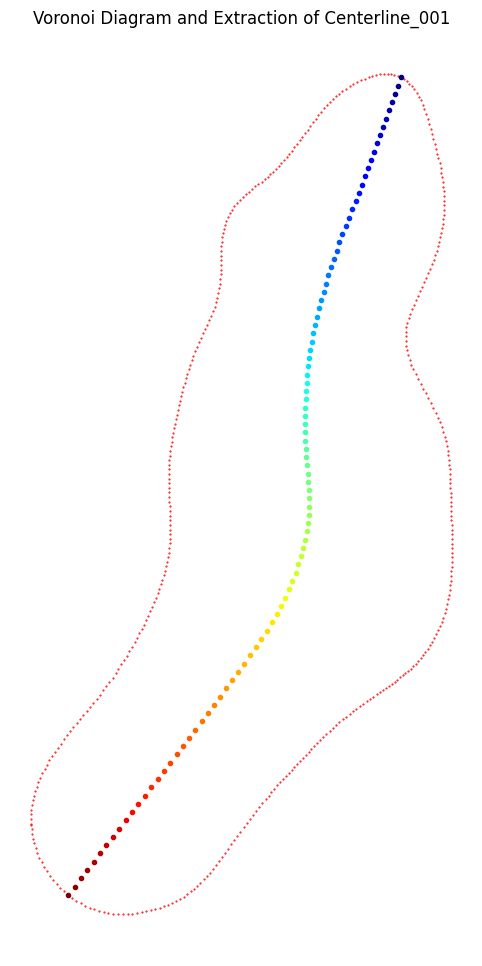

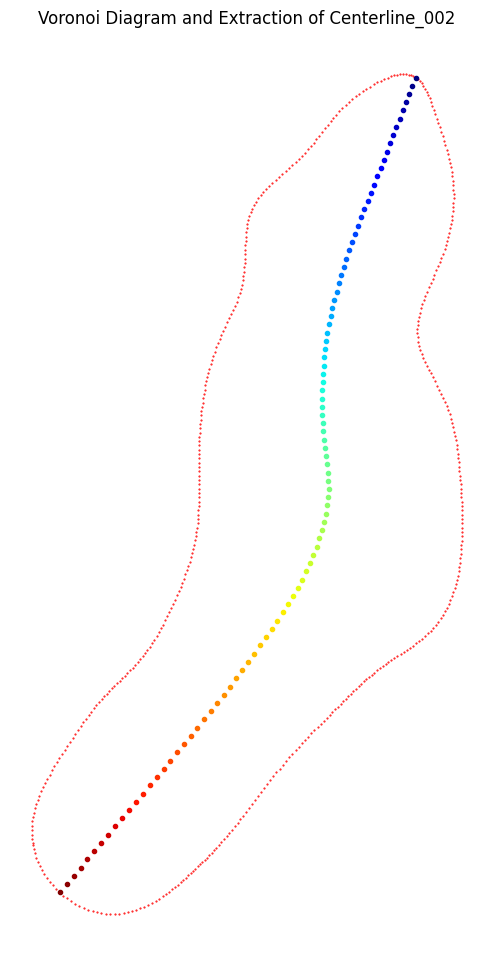

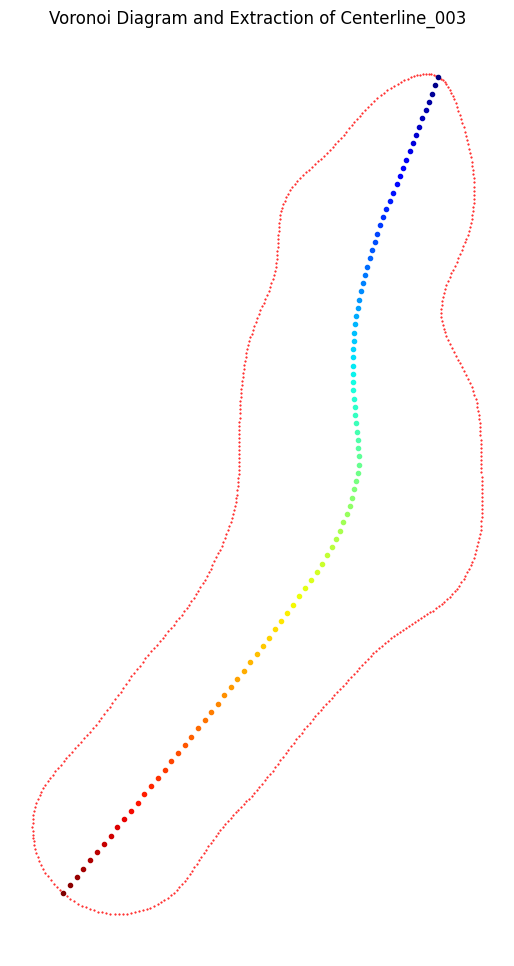

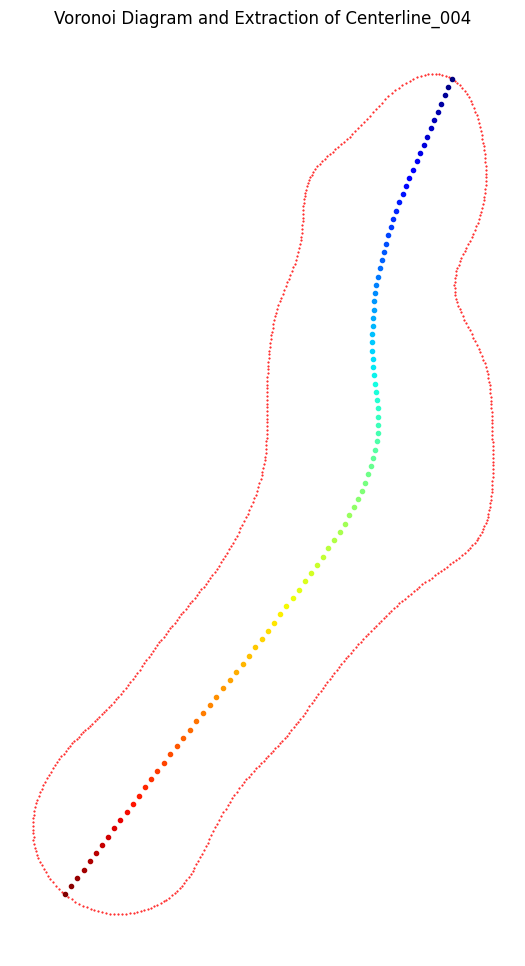

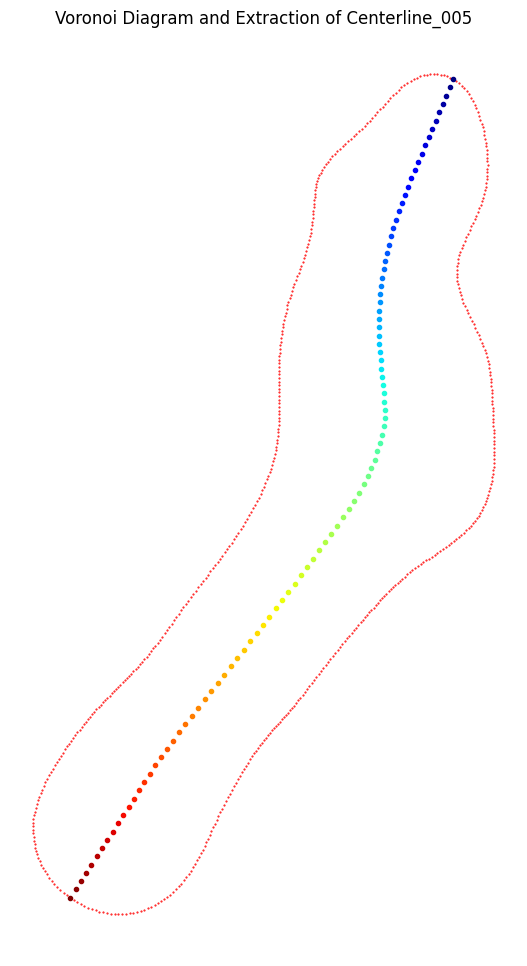

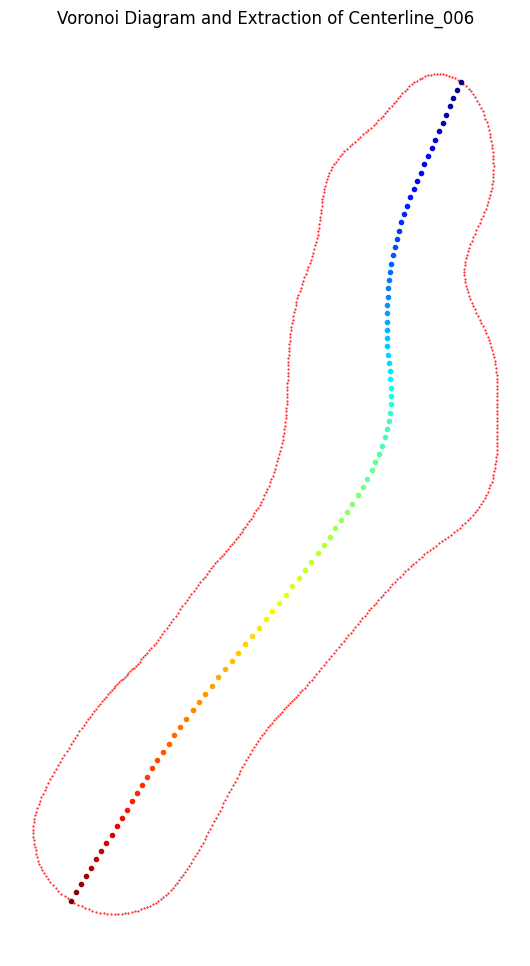

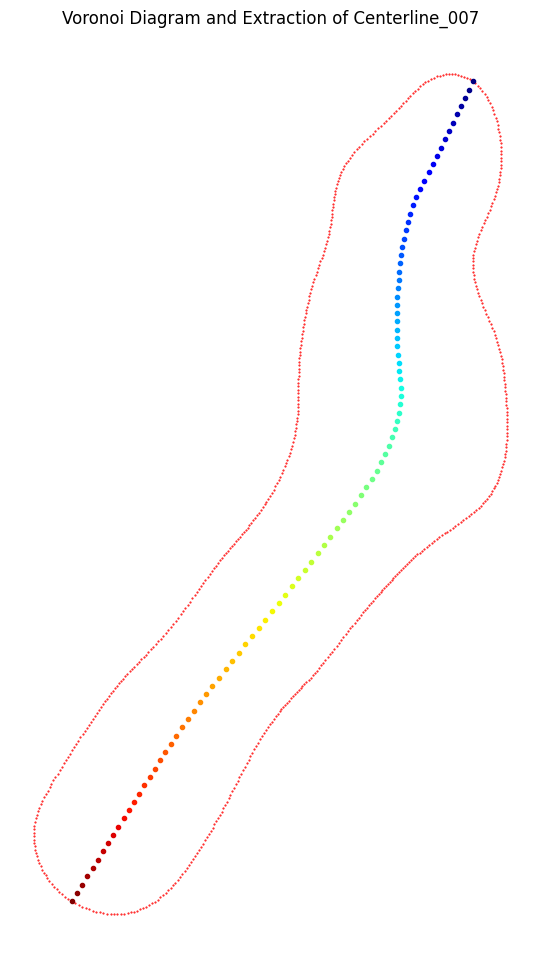

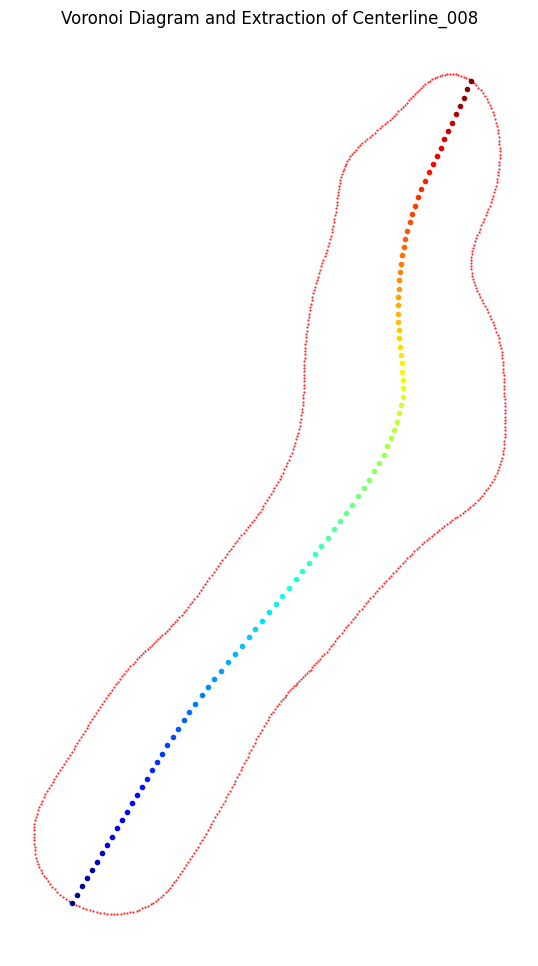

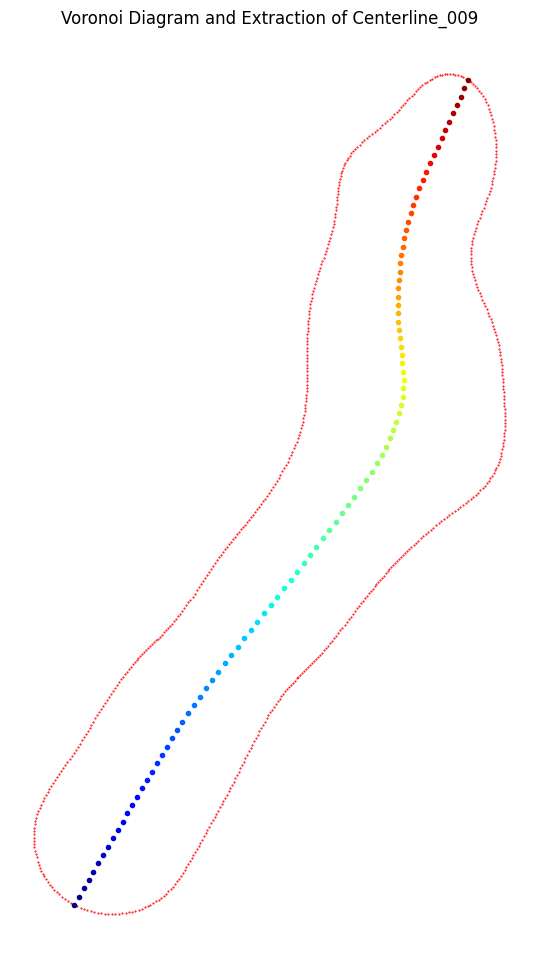

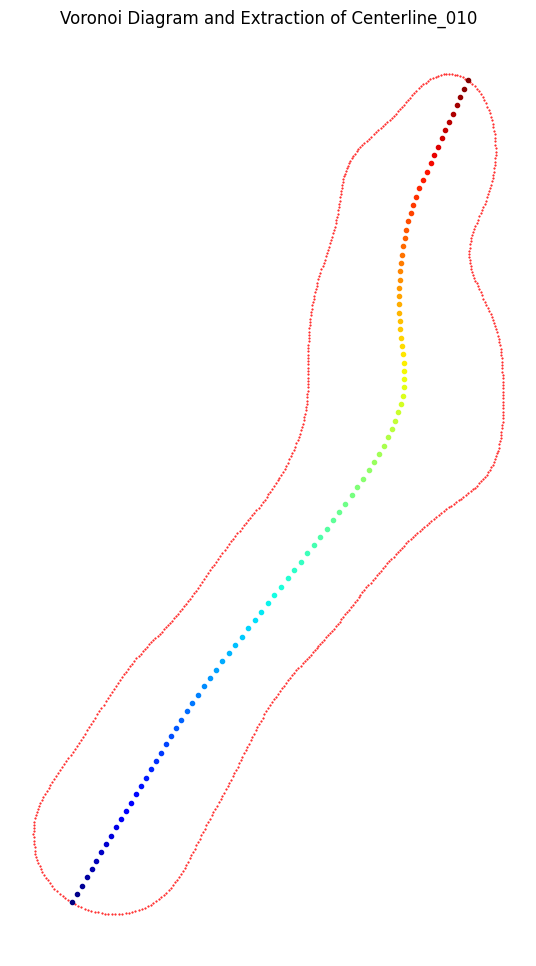

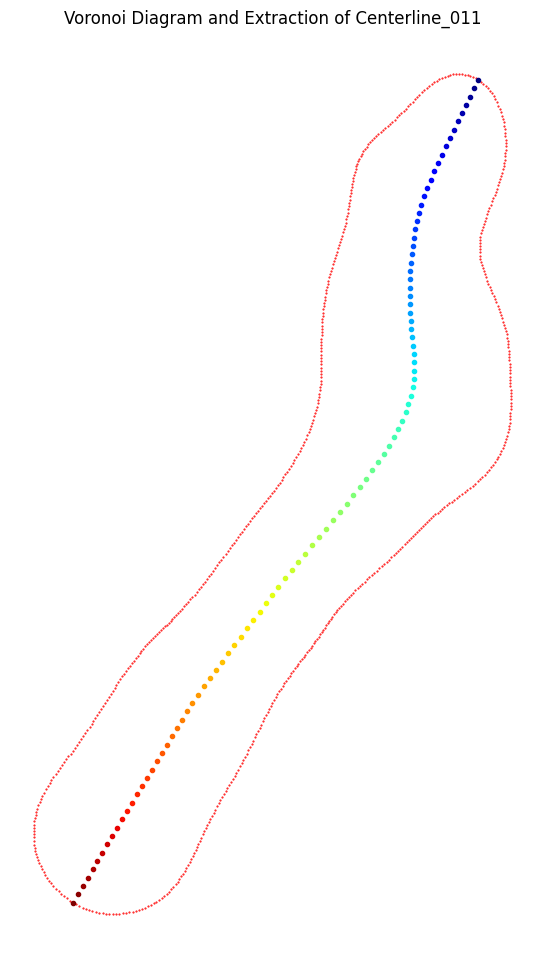

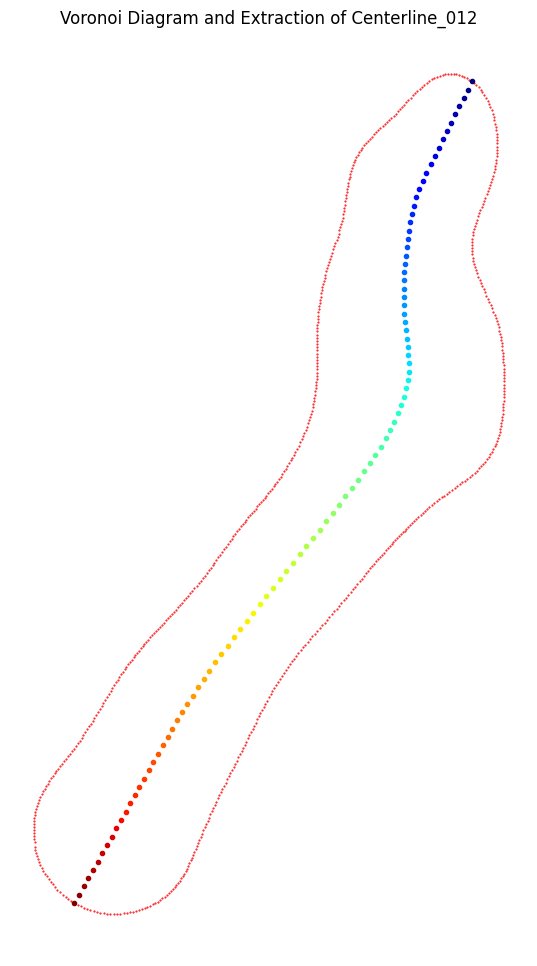

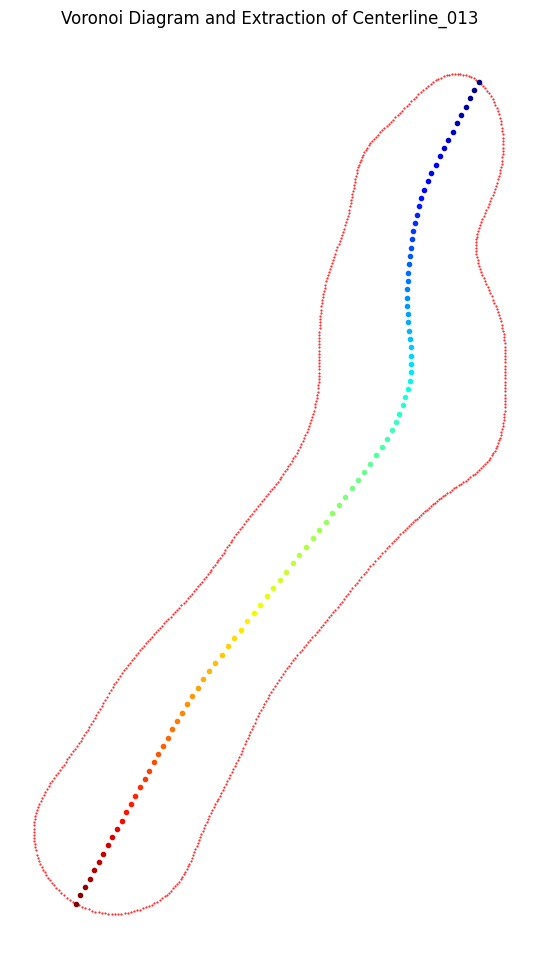

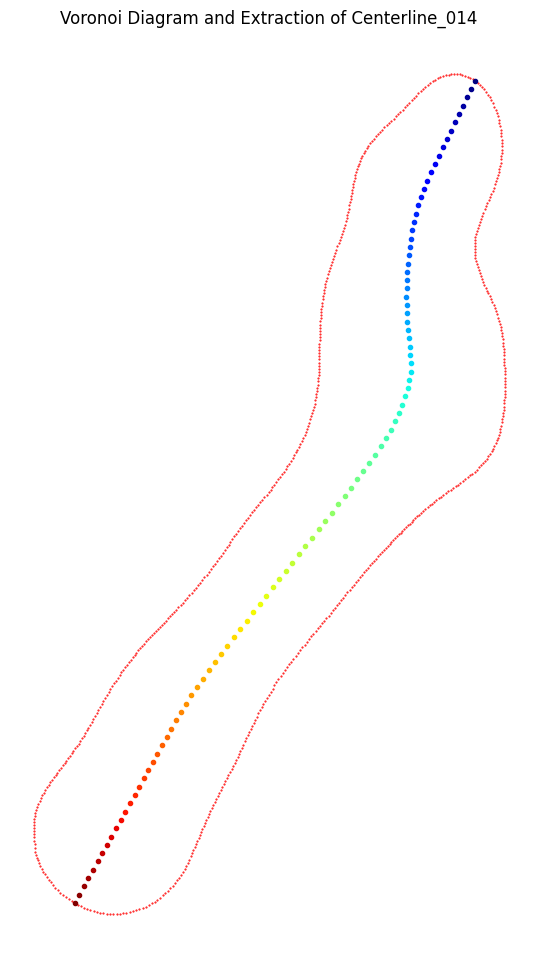

In [8]:
for fi in samples:
    for it in range(t):
        # --- Load edge contour data ---
        edge_file = f"{path}/{edge_folder}/{fname}_{it:03d}.txt"
        yx = np.loadtxt(edge_file)

        # --- Voronoi diagram from contour ---
        vor = scipy.spatial.Voronoi(yx)
        ph = mplPath.Path(yx)
        inside_mask = ph.contains_points(vor.vertices)
        inside_vertices = set(np.where(inside_mask)[0])
        valid_ridges = filter(lambda r: r[0] in inside_vertices and r[1] in inside_vertices,
                              vor.ridge_vertices)

        # --- Build graph from Voronoi edges ---
        g = nx.Graph()
        for v in inside_vertices:
            g.add_node(v)
        for r in valid_ridges:
            dist = np.linalg.norm(vor.vertices[r[0]] - vor.vertices[r[1]])
            g.add_edge(r[0], r[1], weight=dist)

        # --- Find longest shortest path (centerline candidate) ---
        endpoints = [v for v in inside_vertices if len(list(g.neighbors(v))) == 1]
        max_len, best_path = 0, []
        for e1, e2 in itertools.combinations(endpoints, 2):
            try:
                path_len = nx.shortest_path_length(g, e1, e2, weight='weight')
                if path_len > max_len:
                    max_len = path_len
                    best_path = nx.shortest_path(g, e1, e2, weight='weight')
            except nx.NetworkXNoPath:
                continue

        # --- Smooth the centerline using moving average ---
        trimmed = best_path[round(len(best_path)*m1):round(len(best_path)*m2)]
        mid_points = np.array([vor.vertices[i] for i in trimmed])
        smoothed_x = moving_avg(mid_points[:, 0], mm)
        smoothed_y = moving_avg(mid_points[:, 1], mm)
        centerline = np.vstack([smoothed_x, smoothed_y]).T

        # --- Extend the centerline toward ends using average direction ---
        v1 = -np.sum([(centerline[i+1] - centerline[i]) / np.linalg.norm(centerline[i+1] - centerline[i]) for i in range(o)], axis=0) / o
        v2 = np.sum([(centerline[-1-i] - centerline[-2-i]) / np.linalg.norm(centerline[-1-i] - centerline[-2-i]) for i in range(o)], axis=0) / o

        # Find closest points in yx based on direction projection
        l1 = [np.dot(v1, (p - centerline[0]) / np.linalg.norm(p - centerline[0])) for p in yx]
        l2 = [np.dot(v2, (p - centerline[-1]) / np.linalg.norm(p - centerline[-1])) for p in yx]
        extended_line = [yx[np.argmax(l1)]] + list(centerline) + [yx[np.argmax(l2)]]
        extended_line = np.array(extended_line)

        # --- Interpolate to regular spacing ---
        if abs(extended_line[0, 1] - extended_line[-1, 1]) > abs(extended_line[0, 0] - extended_line[-1, 0]):
            interp = interpolate.interp1d(extended_line[:, 1], extended_line[:, 0], kind='slinear')
            x_vals = np.linspace(extended_line[0, 1], extended_line[-1, 1], 100)
            y_vals = interp(x_vals)
        else:
            interp = interpolate.interp1d(extended_line[:, 0], extended_line[:, 1], kind='slinear')
            y_vals = np.linspace(extended_line[0, 0], extended_line[-1, 0], 100)
            x_vals = interp(y_vals)
        final_centerline = np.vstack([y_vals, x_vals]).T

        # --- Save result ---
        os.makedirs(f"{path}/centerline", exist_ok=True)
        os.makedirs(f"{path}/centerline(Fig)", exist_ok=True)
        np.savetxt(f"{path}/centerline/{fname}_{it:03d}.txt", final_centerline)

        # --- Plot and save figure ---
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_title(f"Voronoi Diagram and Extraction of Centerline_{it:03d}")
        ax.plot(yx[:, 1], yx[:, 0], 'r.', markersize=1)
        cmap = plt.get_cmap('jet', len(final_centerline))
        for i, pt in enumerate(final_centerline):
            ax.plot(pt[1], pt[0], '.', color=cmap(i))
        ax.set_aspect('equal')
        ax.axis('off')
        plt.savefig(f"{path}/centerline(Fig)/{fname}_{it:03d}.png", bbox_inches='tight', dpi=300)
        plt.show()